In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# -------------------
# 1. Setup
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r"C:\Users\94718\OneDrive\Desktop\NIBM\AI\CourseWork\code\try2\Preprocessed"    # Local path
batch_size = 32          # Increased batch size for better gradient estimates
num_classes = 4
epochs = 10              # More epochs for sufficient training
learning_rate = 1e-4     # Lower LR for stable convergence
weight_decay = 1e-4      # Regularization

# -------------------
# 2. Data Transforms
# -------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#pretrained resnet model
model = models.resnet18(pretrained=True)

# Freeze base layers to retain pretrained features
for param in model.parameters():
    param.requires_grad = False

# Custom classifier for our dataset
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = model.to(device)

#loss optimizer with Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

# -------------------
# 5. Training Loop
# -------------------
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} "
          f"Acc: {100*correct/total:.2f}%")

#eval
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100*correct/total:.2f}%")

#model save
torch.save(model.state_dict(), "resnet18_cancer_model.pth")

#predicts
classes = dataset.classes

def show_predictions():
    model.eval()
    images, labels = next(iter(test_loader))

    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    plt.figure(figsize=(12, 6))
    num_imgs = min(6, images.size(0))
    for i in range(num_imgs):
        img = images[i].cpu() * std + mean   # Unnormalize
        img = img.clamp(0, 1)
        plt.subplot(2, 3, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
        plt.axis("off")
        
    plt.show()


c:\Users\94718\Downloads\CW\ANN-based-Acute-Lymphoblastic-Leukemia-Classifier\ann_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\94718\Downloads\CW\ANN-based-Acute-Lymphoblastic-Leukemia-Classifier\ann_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\94718/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 23.1MB/s]


Epoch [1/10] Loss: 1.0146 Acc: 66.52%
Epoch [2/10] Loss: 0.5370 Acc: 88.28%
Epoch [3/10] Loss: 0.3460 Acc: 92.66%
Epoch [4/10] Loss: 0.2592 Acc: 94.57%
Epoch [5/10] Loss: 0.2060 Acc: 95.31%
Epoch [6/10] Loss: 0.1699 Acc: 95.86%
Epoch [7/10] Loss: 0.1511 Acc: 96.29%
Epoch [8/10] Loss: 0.1424 Acc: 96.25%
Epoch [9/10] Loss: 0.1272 Acc: 96.84%
Epoch [10/10] Loss: 0.1017 Acc: 97.73%
Test Accuracy: 99.06%


Test Accuracy: 99.06%


<Figure size 800x600 with 0 Axes>

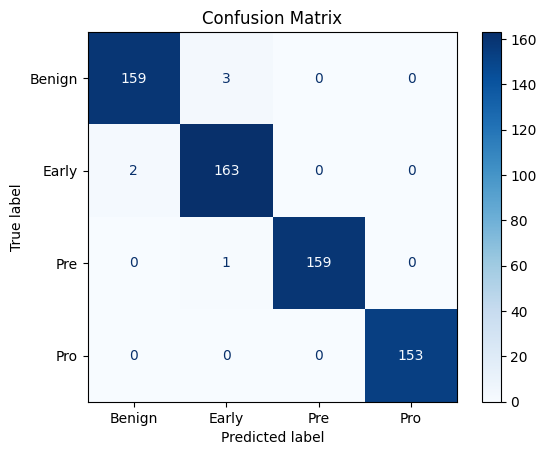

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# -------------------
# 6. Evaluation + Confusion Matrix
# -------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {100*acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()
